In [105]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

### Data Preprocessing ###

In [2]:
# importing the data
filepath = '/Users/karlokng/Downloads/data/creditcard.csv'
data = pd.read_csv(filepath)
# 'Time' is time elapsed from first transaction of dataset
# V1-V28 are the PCA components
# Amount is the transaction amount
# Positive class (i.e. 1) is fraud, negative class (i.e. 0) is not fraud.
# we wish to detect and handle outliers for all the numerical features in the data set.
# I will use z-score for outlier detection. 

# code from lab 2. 
def z_score_filter(data_col, threshold= 3):
    """
    Description: A z_score filter that assigns each element \
        True if outlier, False otherwise
    Input: A Series of numerical data (int or floats), \
        optionally a custom threshold
    Output: A Series of boolean values
    """
    data_mean = data_col.mean()
    data_sd = data_col.std()

    # Now I calculate the z_score
    z_score = (data_col - data_mean)/data_sd

    return pd.Series([(element < -threshold or element > threshold) \
                      for element in z_score], index= data_col.index)

# iterate function over all columns
for col in data.columns[:-1]: # iterate over all columns except for class
    data[col + '_z_score'] = z_score_filter(data[col])

# getting the columns to filter on
filter_columns = [col for col in data if col.endswith('_z_score')]

for col in filter_columns:
    # get the indices of the outliers in this column
    idx = data[data[col]].index
    # drop the outliers
    data.drop(idx, axis= 0, inplace= True)

# checking if all the outliers are taken care of
print(data[filter_columns].sum().sum())

# dropping the indicator columns I just made now that I'm done with them
data.drop(filter_columns, axis= 1, inplace= True)

# check resulting dataframe to see how much data is left
print(data.shape)
display(data)

0
(246991, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284800,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0
284801,172785.0,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0


In [3]:
# checking ranges in the columns to see if I should normalize
for col in data.columns[:-1]:
    print(data[col].max() - data[col].min())

172792.0
8.32705466544255
9.89849927657432
8.63638287943787
8.489687925581698
8.25556928744708
7.92598967347155
7.37778347510833
7.1540905227738705
6.588006067890181
6.51131993807866
6.09815154140999
5.78384195040972
5.96814731722727
5.74761647051025
5.49060309430583
5.22934837153033
4.748727436870849
5.02862248982756
4.88355107434502
4.60622082428627
4.38363756015058
4.350406562488571
3.7283169492430597
3.2042803494743897
3.12743443617826
2.88689983689746
2.42110184807048
1.977978625638149
838.07


We see that the PCA components all have relatively similar range, but Time and Amount (which aren't PCA components) have much larger ranges. As such, I think we should normalize those two columns specifically

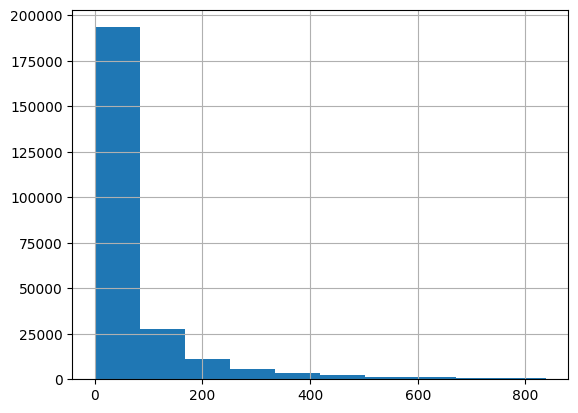

In [4]:
# since Time is ordinal, it would make sense for us to use min-max scaling
# to preserve the ordinal information
data['Time'] = (data['Time'] - data['Time'].min())/ \
    (data['Time'].max() - data['Time'].min())

# checking distribution of the ['Amount'] column
data['Amount'].hist()

# we see that the amount is heavily right skewed
# as such, min-max scaling may not work well
# we could try robust scaling
data['Amount'] = (data['Amount'] - data['Amount'].quantile(0.5))/ \
    (data['Amount'].quantile(0.25) - data['Amount'].quantile(0.75))

In [5]:
# the ranges are much more reasonably close now. 
print(data['Time'].max() - data['Time'].min())
print(data['Amount'].max() - data['Amount'].min())

1.0
12.969204580625194


### Descriptive Analytics ###

In [6]:
print(data[data['Class'] == 0].shape)
print(data[data['Class'] == 1].shape)

(246943, 31)
(48, 31)


The original data set had 492 cases of fraud. It seems that in removing the outliers, we have kind of decimated the positive class. Intuitively it kind of makes sense, as "outlier" transactions would probably be a higher chance to be fraud. 

I will re-run the outlier detection, but stratified between fraud and non-fraud cases. This way, we may remove outliers between the two cases more appropriately. 

In [7]:
# re-running outlier detection with a higher threshold
data = pd.read_csv(filepath)

print("Before outlier removal: ")
print(data[data['Class'] == 0].shape)
print(data[data['Class'] == 1].shape)
# splitting to 2 subsets
data_neg = data[data['Class'] == 0].copy()
data_pos = data[data['Class'] == 1].copy()

# running the z_score_filter
for col in data.columns[:-1]:
    data_neg[col + '_z_score'] = z_score_filter(data_neg[col], threshold= 3)
    data_pos[col + '_z_score'] = z_score_filter(data_pos[col], threshold= 3)

# combining them back
data = pd.concat([data_neg, data_pos]).sort_index()

# the rest of it goes the same as before
filter_columns = [col for col in data if col.endswith('_z_score')]

for col in filter_columns:
    idx = data[data[col]].index
    data.drop(idx, axis= 0, inplace= True)

# re-running normalization
data['Time'] = (data['Time'] - data['Time'].min())/ \
    (data['Time'].max() - data['Time'].min())
data['Amount'] = (data['Amount'] - data['Amount'].quantile(0.5))/ \
    (data['Amount'].quantile(0.25) - data['Amount'].quantile(0.75))

data.drop(filter_columns, axis= 1, inplace= True)

print("")
print("After outlier removal: ")
print(data[data['Class'] == 0].shape)
print(data[data['Class'] == 1].shape)

Before outlier removal: 
(284315, 31)
(492, 31)

After outlier removal: 
(244155, 31)
(442, 31)


With this more nuanced way to check for outliers, we've preserved many more observations of fraud than before. 

In [8]:
# Analyzing correlation

# custom correlation function to compute p-values later on
def pearsonr_pval(x, y):
    return pearsonr(x,y)[1]

corr_coeff_df = data.corr()
p_val_coeff_df = data.corr(method= pearsonr_pval)

display(p_val_coeff_df['Class'].sort_values())

V10        0.000000e+00
V16        0.000000e+00
V21        0.000000e+00
V14        0.000000e+00
V12        0.000000e+00
V11        0.000000e+00
V17        0.000000e+00
V8         0.000000e+00
V9         0.000000e+00
V5         0.000000e+00
V4         0.000000e+00
V3         0.000000e+00
V2         0.000000e+00
V1         0.000000e+00
V7         0.000000e+00
V18        0.000000e+00
V6        3.588570e-168
V27       3.292951e-115
V19        1.203296e-97
V20        1.416010e-94
V28        4.838884e-29
Time       2.500622e-10
Amount     9.773619e-09
V24        6.255540e-05
V26        1.559947e-03
V25        6.707967e-03
V22        3.899243e-02
V15        4.052849e-01
V13        4.516722e-01
V23        8.752000e-01
Class      1.000000e+00
Name: Class, dtype: float64

We see that almost every column is statistically signficantly correlated to the class to a significance level of 0.05. The only features that are not statistically significantly correlated are V23, V13 and V15. 

In [9]:
display(corr_coeff_df['Class'].sort_values())

V14      -0.370582
V17      -0.370234
V12      -0.300812
V10      -0.276434
V7       -0.238932
V16      -0.215112
V3       -0.202955
V1       -0.122956
V18      -0.113877
V5       -0.106158
V9       -0.105387
V6       -0.055846
Time     -0.012792
Amount   -0.011595
V24      -0.008094
V15      -0.001683
V13      -0.001522
V23      -0.000318
V22       0.004174
V25       0.005482
V26       0.006396
V28       0.022613
V20       0.041699
V19       0.042384
V27       0.046106
V21       0.086859
V8        0.093404
V2        0.132580
V4        0.148670
V11       0.161852
Class     1.000000
Name: Class, dtype: float64

We see that the magnitude of the correlation coefficients are not very big either. V11 (the feature with the highest positive correlation coefficient) has a value of 0.16, and V14 (the feature with the highest negative correlation coefficient) has a value of -0.37. This indicates relatively weak linear correlation between these features and the class value. Non-linear correlation is not captured within this measure. 

In [10]:
# choose top 10
# I'll choose the 5 highest and 5 lowest correlation value, 
# with the assumption that stronger correlation strength would be helpful in prediction
 
# [:-1] to ignore the correlation of Class with itself
top5 = corr_coeff_df['Class'][:-1].sort_values().nlargest(5).index
bottom5 = corr_coeff_df['Class'][:-1].sort_values().nsmallest(5).index

selected_features = list(bottom5) + list(top5)
print(selected_features)

['V14', 'V17', 'V12', 'V10', 'V7', 'V11', 'V4', 'V2', 'V8', 'V21']


In [11]:
# plot their distributions against Class

# first, subset the dataframe for these 10 features
data_selected = data[selected_features + ['Class']]

#for col in selected_features:
#    data_selected.plot.bar(x= col, y= 'Class')

### ML Model Training and Testing ###

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data_selected[selected_features],
                                                    data_selected['Class'],
                                                    test_size= 0.2)

# train logistic regression model 
cv_dict_logistic = cross_validate(LogisticRegression(),
                                  X_train, y_train, cv= 5, return_estimator= True)
df = pd.DataFrame(columns= X_train.columns)
for i in range(0, 5):
    val_lst = cv_dict_logistic['estimator'][i].coef_[0]
    df.loc[i] = val_lst
display(df)

,V14,V17,V12,V10,V7,V11,V4,V2,V8,V21
0,-1.353705,-0.182913,-1.039343,-0.767856,0.002999,0.583304,1.251555,-0.533378,-1.193843,0.403176
1,-1.458666,-0.386195,-1.220594,-0.706189,-0.005311,0.516834,1.250553,-0.544502,-1.277705,0.337533
2,-1.444620,-0.352684,-1.037526,-0.673436,0.134119,0.637241,1.123978,-0.372569,-1.106991,0.254811
3,-1.498657,-0.378811,-1.011955,-0.769161,0.139376,0.691216,1.230724,-0.563043,-1.109582,0.344454
4,-1.329486,-0.294862,-1.001625,-0.920978,0.056579,0.612295,1.314392,-0.486721,-1.174319,0.416366


In the 5-fold cross validation, the trained models seem to give V14, V4, and V8 the most weight. 

In [94]:
# validate logistic regression model 
cv_dict_logistic_test = cross_validate(LogisticRegression(),
                                       X_test, y_test, cv= 5,
                                       scoring= ['accuracy', 'precision', 'recall', 'f1'])

res_df = pd.DataFrame([cv_dict_logistic_test['test_accuracy'], 
                       cv_dict_logistic_test['test_precision'], 
                       cv_dict_logistic_test['test_recall'], 
                       cv_dict_logistic_test['test_f1']],
                       index = ['accuracy', 'precision', 'recall', 'f1'],
                       columns= range(0,5))

display(res_df)

,0,1,2,3,4
accuracy,0.999796,0.999591,0.999898,0.999796,0.999898
precision,1.000000,1.000000,1.000000,0.923077,1.000000
recall,0.833333,0.692308,0.923077,0.923077,0.923077
f1,0.909091,0.818182,0.960000,0.923077,0.960000


Given the very imbalanced classes, we must consider the results of a dummy model where it simply predicts the majority class. The majority class here is class 0, and thus a model that simply predicts 0 for every item in the test set would, on average, attain a result of about 99%. We attain this value by the fact that there are only 442 positive cases in our full data set, and 244155 cases of negative cases. As such, if it predicts class 0 for every observation in our test set, it would get $\frac{442}{244155} \approx 0.99$ in accuracy. Given this baseline, our model's $\approx 0.99$ accuracy score is a lot less impressive than taken at face value. As such, the other measures may offer more insight into the performance of our model. 

Precision is defined as $\frac{TP}{TP + FP}$. In plain language, it is the number of correctly labelled positive observations out of all the observations that were identified as the positive class. Our model scored 100% in all 5 instances of the 5-fold cross validation. This means that, of the cases identified as fraud, they were all indeed cases of fraud. 

Recall is defined as $\frac{TP}{TP + FN}$. It is the number of correctly labelled positive observations out of all the positive observations within the data set. Our model seems to fluctuate quite wildly between low and high observation scores. This implies that our model's recall performance is quite dependent on the exact sample of data set we feed it. This could potentially indicate an overfitting issue. Alternatively this could indicate that we still have too few cases of fraud in our data set, as some of the partitions may contain no fraud, and thus there isn't any "positive observations" within this partition of the dataset. 

F1 score is defined as $\frac{2TP}{2TP + FP + FN}$. It is a harmonic mean of precision and recall. It seeks to find a balance between precision and recall. Since our precision is 100% across all 5 cross validations, our f1 score fluctuates similarly to our recall. However, it flucuates less as it is "balanced out" by the constant precision score. 

0.953125


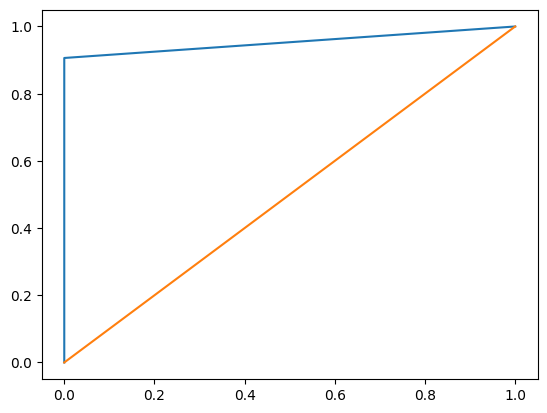

In [79]:
# Using the test set to make predictions
model = LogisticRegression()
model.fit(X_train, y_train)
y_score = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_score)
print(roc_auc_score(y_test, y_score))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

We see that the model outperforms a random classifier, and it seems to be quite appreciably close to the perfect classifier. 
The AUC metric also indicates that th emodel preddicts the positive classes with very high confidence. These are good signs for our logistic regression model. 

In [99]:
# we can add class weights to our logistic regression model. 
# the 'balanced' mode uses counts of y to adjust the sample weight
# It is inversely proportional to class frequencies, and is given by
#n_samples / (n_classes * np.bincount(y)).
cv_dict_logistic_test_weighted = cross_validate(LogisticRegression(class_weight='balanced'),
                                       X_test, y_test, cv= 5,
                                       scoring= ['accuracy', 'precision', 'recall', 'f1'])

res_weighted_df = pd.DataFrame([cv_dict_logistic_test_weighted['test_accuracy'], 
                       cv_dict_logistic_test_weighted['test_precision'], 
                       cv_dict_logistic_test_weighted['test_recall'], 
                       cv_dict_logistic_test_weighted['test_f1']],
                       index = ['accuracy', 'precision', 'recall', 'f1'],
                       columns= range(0,5))

# printing out the class weight just for fun.
print(len(y_test)/(2 * np.bincount(y_test)))
display(res_weighted_df)

[  0.50065499 382.1875    ]


,0,1,2,3,4
accuracy,0.981092,0.999591,0.980683,0.981500,0.980989
precision,0.056410,1.000000,0.064356,0.067010,0.065327
recall,0.916667,0.692308,1.000000,1.000000,1.000000
f1,0.106280,0.818182,0.120930,0.125604,0.122642


We observe that the performance is quite different. In this case, the precision metric crumbles to nearly 0, with 1 set wildly fluctuating to 1. This could be a case where there are no positive cases in this fold, and thus everything is predicted to be the negative case and achieving a result of a 100%. 

The recall, in turn, mostly achieves a high value of 70% to 100%. 

The f1 score, being a harmonic mean of the two, is very low when precision is low. 

This indicates to us that our model really doesn't work very well when the class imbalance is addressed. As such, perhaps other methods may perform better.

In [113]:
cv_dict_neighbour_test = cross_validate(KNeighborsClassifier(),
                                       X_test, y_test, cv= 5,
                                       scoring= ['accuracy', 'precision', 'recall', 'f1'])

res_neighbour_df = pd.DataFrame([cv_dict_neighbour_test['test_accuracy'], 
                       cv_dict_neighbour_test['test_precision'], 
                       cv_dict_neighbour_test['test_recall'], 
                       cv_dict_neighbour_test['test_f1']],
                       index = ['accuracy', 'precision', 'recall', 'f1'],
                       columns= range(0,5))

cv_dict_svm_test = cross_validate(LinearSVC(max_iter= 10000),
                                       X_test, y_test, cv= 5,
                                       scoring= ['accuracy', 'precision', 'recall', 'f1'])

res_svm_df = pd.DataFrame([cv_dict_svm_test['test_accuracy'], 
                       cv_dict_svm_test['test_precision'], 
                       cv_dict_svm_test['test_recall'], 
                       cv_dict_svm_test['test_f1']],
                       index = ['accuracy', 'precision', 'recall', 'f1'],
                       columns= range(0,5))

display(res_neighbour_df)
display(res_svm_df)

,0,1,2,3,4
accuracy,0.999796,0.999591,0.999796,0.999898,0.999898
precision,1.000000,1.000000,1.000000,1.000000,1.000000
recall,0.833333,0.692308,0.846154,0.923077,0.923077
f1,0.909091,0.818182,0.916667,0.960000,0.960000


,0,1,2,3,4
accuracy,0.999796,0.999591,0.999796,0.999898,0.999898
precision,1.000000,1.000000,1.000000,1.000000,1.000000
recall,0.833333,0.692308,0.846154,0.923077,0.923077
f1,0.909091,0.818182,0.916667,0.960000,0.960000


We observe a similar behaviour from the KNN and SVM classifiers to our logistic regression. Namely, the Precision seems abnormally high, and the Recall seems to fluctuate between iterations, and the f1-score reflecting this variance as well. 

I note that, when setting class_weights= 'balanced' for the LinearSVC function, it does not converge even after increasing the max iteration to 10,000. 

Further testing could be done to rectify the class imbalance problem in another way (perhaps with over/under sampling), potentially giving us more stable results from our models. 